# AI-Based Trading Strategies
## Attention LSTM Trading Strategy
An AI-driven trading framework leveraging an Attention-LSTM architecture to forecast market dynamics and backtest systematic long/short strategies on SPY
## Setup & Data Prep

### Import Libraries & Dependencies

In [1]:
# --- Imports ---
import os, random, warnings
from pathlib import Path; from dataclasses import dataclass
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, Lambda
from tensorflow.keras.models import Model
try: from tensorflow.keras.optimizers.legacy import Adam
except: from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from hmmlearn.hmm import GaussianHMM

# --- Globals ---
OUTPUT_DIR = Path("../outputs/04_ATT_LSTM_clean"); OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Reproducibility ---
SEED=42; os.environ["PYTHONHASHSEED"]=str(SEED); os.environ["TF_DETERMINISTIC_OPS"]="1"
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# --- Params ---
PRED_THRESHOLD=0.46; THRESH_BAND=0.05
LONG_THRESHOLD,SHORT_THRESHOLD=PRED_THRESHOLD+THRESH_BAND,PRED_THRESHOLD-THRESH_BAND
SEQ_LEN=28; H_SPLIT="2022-01-01"
print(f"Thresholds -> SHORT={SHORT_THRESHOLD:.2f}, LONG={LONG_THRESHOLD:.2f}")


Thresholds -> SHORT=0.41, LONG=0.51


In [2]:
# --- Load Local Dataset ---
data_path = Path('../data/GSPC_fixed.csv')
if not data_path.exists():
    raise FileNotFoundError(f"Dataset not found at {data_path.resolve()}")

df = pd.read_csv(
    data_path,
    parse_dates=['Date'],
    index_col='Date'
).sort_index()

df.columns = [col.lower() for col in df.columns]

numeric_cols = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df.ffill(inplace=True)

display(df.head())
display(df.tail())


,open,high,low,close,adjusted_close,volume
Date,,,,,,
2014-01-06,1832.3101,1837.16,1823.7300,1826.77,1826.77,3294850000
2014-01-07,1828.7100,1840.10,1828.7100,1837.88,1837.88,3511750000
2014-01-08,1837.9000,1840.02,1831.4000,1837.49,1837.49,3652140000
2014-01-09,1839.0000,1843.23,1830.3800,1838.13,1838.13,3581150000
2014-01-10,1840.0601,1843.15,1832.4301,1842.37,1842.37,3335710000


,open,high,low,close,adjusted_close,volume
Date,,,,,,
2025-03-03,5968.3301,5986.0898,5810.9102,5849.7202,5849.7202,5613850000
2025-03-04,5811.9800,5865.0801,5732.5898,5778.1499,5778.1499,6138110000
2025-03-05,5781.3599,5860.5898,5742.3501,5842.6299,5842.6299,5285970000
2025-03-06,5785.8701,5812.0801,5711.6401,5738.5200,5738.5200,5165080000
2025-03-07,5726.0098,5783.0098,5666.2900,5770.2002,5770.2002,5705140000


## Data Visualization
- Plot **S&P 500 adjusted closing prices** over time.

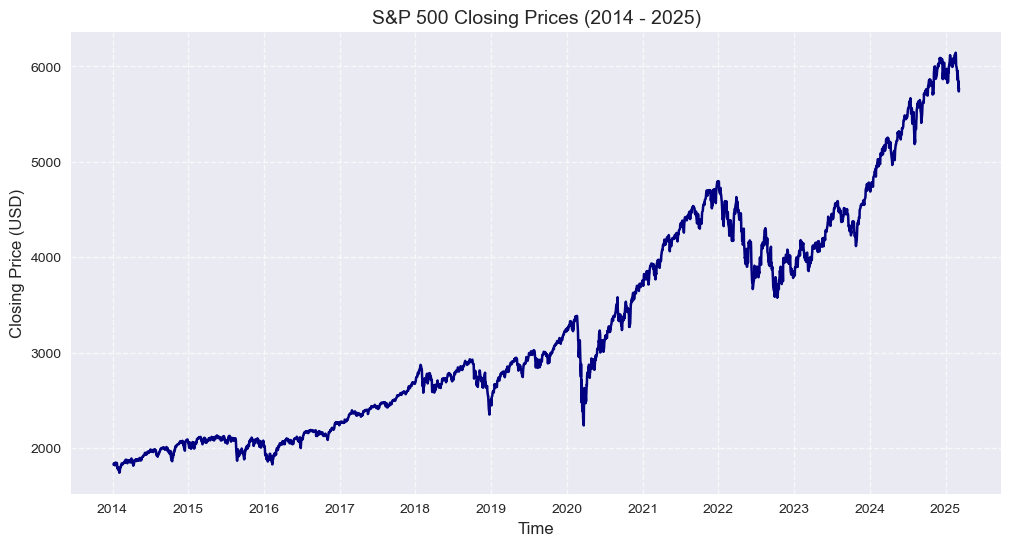

In [3]:
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["adjusted_close"], linewidth=1.8, color='navy')

plt.title("S&P 500 Closing Prices (2014 - 2025)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Closing Price (USD)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  

plt.show()


## Feature Engineering 

In [4]:
# Compute log returns
df["log_returns"] = np.log(df["adjusted_close"] / df["adjusted_close"].shift(1))

### Technical Indicators
LSTM models **learn temporal patterns from sequences**, so we select indicators that enhance **trend detection, volatility awareness, and momentum signals**.  
These features enrich the input data, giving the model information about **trend strength, volatility regimes, and volume confirmation**.

---

| **Category**              | **Indicator**                           | **Best Periods**         | **Why Useful?**                                                                 |
|---------------------------|-----------------------------------------|--------------------------|---------------------------------------------------------------------------------|
| **Return Feature**        | Log Returns                             | 1-day                    | Captures raw daily price dynamics; foundation for return-based modeling         |
| **Volatility Indicator**  | Rolling Std. of Returns                 | Vol(10)                  | Tracks short-term volatility regimes; helps size positions and detect turbulence|
| **Momentum Indicator**    | RSI (Relative Strength Index)           | RSI(14)                  | Detects momentum extremes and overbought/oversold conditions                    |
| **Momentum Indicator**    | MACD (Moving Avg Convergence Divergence)| MACD(12,26,9)            | Highlights momentum shifts and potential trend reversals                        |
| **Volume Indicator**      | OBV (On-Balance Volume)                 | Default (cumulative)     | Confirms price moves with volume flow                                           |
| **Lagged Features**       | Lagged Log Returns                      | lag_1 … lag_7 (7 lags)   | Provide temporal context and allow LSTM to capture autocorrelation structures   |

---

In [5]:
# ===========================================
# Feature Engineering (with lagged returns)
# ===========================================

# Compute log returns
df["log_returns"] = np.log(df["adjusted_close"] / df["adjusted_close"].shift(1))


def ensure_log_returns(df):
    if "log_returns" not in df:
        df["log_returns"] = np.log(df["adjusted_close"]).diff().fillna(0.0)
    return df


def ema(s, span): 
    return s.ewm(span=span, adjust=False).mean()


def add_technical_features(df, lags=7):
    df = df.copy()
    px = df["adjusted_close"]

    # Volatility window
    df["volatility_10"] = (
        df["log_returns"].rolling(10).std()
        .fillna(df["log_returns"].expanding().std())
    )

    # RSI(14)
    delta = px.diff()
    up, down = delta.clip(lower=0), -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/14, adjust=False).mean()
    roll_down = down.ewm(alpha=1/14, adjust=False).mean()
    rs = (roll_up / (roll_down.replace(0, np.nan))).fillna(0)
    df["RSI_14"] = (100 - (100 / (1 + rs))).fillna(50)

    # MACD (12,26,9)
    ema12, ema26 = ema(px, 12), ema(px, 26)
    macd = ema12 - ema26
    signal = ema(macd, 9)
    df["MACD"] = (macd - signal).fillna(0)

    # OBV
    if "volume" in df:
        direction = np.sign(px.diff().fillna(0))
        df["OBV"] = (direction * df["volume"]).fillna(0).cumsum()
    else:
        df["OBV"] = 0.0  # safe fallback

    # Lagged log returns (1–lags)
    for lag in range(1, lags + 1):
        df[f"lag_{lag}"] = df["log_returns"].shift(lag)

    return df


# --- Build / clean df ---
df = ensure_log_returns(df)
df = add_technical_features(df, lags=7)

# Feature sets
FEATURE_COLS = [
    "log_returns", "volatility_10", "RSI_14", "MACD", "OBV"
] + [f"lag_{i}" for i in range(1, 8)]

# HMM regime drivers (no lags here)
HMM_FEATURE_COLS = ["log_returns", "volatility_10", "RSI_14", "MACD", "OBV"]

# Target variable: next-day direction
if "label" not in df:
    df["label"] = (df["log_returns"].shift(-1) > 0).astype(int)

# Drop rows with NaNs from lagging & indicators
df = df.dropna(subset=FEATURE_COLS + ["label"]).copy()


## Regime Detection (HMM)

In [6]:
# ===========================================
# Regime Detection: HMM regime features
# ===========================================
@dataclass
class RegimeSpec:
    n_states: int = 3
    covariance_type: str = "diag"
    n_iter: int = 100
    tol: float = 1e-2
    random_state: int = 42
    # reg_covar dropped (older hmmlearn versions don't support it)

def _hmm_fit_transform(train_2d: np.ndarray, test_2d: np.ndarray, spec: RegimeSpec):
    """
    Fit an HMM on training data only, then return posterior probabilities
    (regime features) for both train and test.
    """
    # Standardize features on train only
    sc = StandardScaler().fit(train_2d)
    Ztr, Zte = sc.transform(train_2d), sc.transform(test_2d)

    # Train Gaussian HMM
    hmm = GaussianHMM(
        n_components=spec.n_states,
        covariance_type=spec.covariance_type,
        n_iter=spec.n_iter,
        tol=spec.tol,
        random_state=spec.random_state,
    )
    hmm.fit(Ztr)

    # Posterior regime probabilities (soft one-hot features)
    def post(X):
        _, post = hmm.score_samples(X)
        return post  # shape (n, n_states)

    return post(Ztr), post(Zte)

def fit_transform_regime_features_fold(df, feature_cols, train_idx, val_idx, spec: RegimeSpec):
    """
    Train/val split regime transformation:
    - Fit HMM on train slice
    - Transform both train and val into regime posterior features
    """
    tr = df.loc[train_idx, feature_cols].values
    va = df.loc[val_idx,  feature_cols].values
    Ptr, Pva = _hmm_fit_transform(tr, va, spec)
    return Ptr, Pva


## Sequence builder

In [7]:
def create_sequences(X2d, y1d, seq_length=SEQ_LEN):
    Xv = X2d.values if hasattr(X2d, "values") else np.asarray(X2d)
    yv = y1d.values if hasattr(y1d, "values") else np.asarray(y1d)
    assert len(Xv) == len(yv)
    if len(Xv) < seq_length:
        raise ValueError("Not enough rows for sequence length.")

    # X windows: [i … i+seq_len-1]
    X_seq = np.stack([Xv[i:i+seq_length] for i in range(len(Xv) - seq_length + 1)], axis=0)

    # y aligned with last timestep of each window (index i+seq_len-1)
    y_seq = np.array([yv[i+seq_length-1] for i in range(len(Xv) - seq_length + 1)])

    return X_seq, y_seq


# Model Implementation & Training
## Model Definition & Initialization
### ATT-LSTM (with attention)

In [8]:
# ====================================================
# Stacked Attention-LSTM (2-layer LSTM + Attention)
# ====================================================
def get_stacked_att_lstm(input_shape,
                         lstm_units1=64, lstm_units2=32,
                         dropout=0.2, rec_dropout=0.1, lr=1e-3):
    """Builds a stacked LSTM with temporal attention for binary classification."""
    inputs = Input(shape=input_shape, name="inputs")

    # First LSTM layer (outputs sequences for stacking)
    x = LSTM(lstm_units1, return_sequences=True,
             dropout=dropout, recurrent_dropout=rec_dropout,
             name="lstm_1")(inputs)
    x = BatchNormalization(name="bn_1")(x)

    # Second LSTM layer (still return sequences for attention)
    x = LSTM(lstm_units2, return_sequences=True,
             dropout=dropout, recurrent_dropout=rec_dropout,
             name="lstm_2")(x)
    x = BatchNormalization(name="bn_2")(x)

    # Attention block (temporal softmax over timesteps)
    e = Dense(32, activation="tanh", name="attn_dense")(x)
    e = Dense(1, name="attn_score")(e)
    alpha = tf.nn.softmax(e, axis=1, name="attn_weights")
    context = tf.reduce_sum(alpha * x, axis=1, name="attn_context")

    # Output layer
    outputs = Dense(1, activation="sigmoid", name="output")(context)

    model = Model(inputs, outputs, name="stacked_att_lstm")
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model


In [9]:
model = get_stacked_att_lstm((SEQ_LEN, len(FEATURE_COLS)))
model.summary()

Model: "stacked_att_lstm"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 28, 12)]             0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 28, 64)               19712     ['inputs[0][0]']              
                                                                                                  
 bn_1 (BatchNormalization)   (None, 28, 64)               256       ['lstm_1[0][0]']              
                                                                                                  
 lstm_2 (LSTM)               (None, 28, 32)               12416     ['bn_1[0][0]']                
                                                                                   

## Cross-Validation Diagnostics (Stages A–G)

In [10]:
# ===========================================
# Cross-Validation Diagnostics (Stages A–G)
# ===========================================
tscv = TimeSeriesSplit(n_splits=6, test_size=252)
regime_spec = RegimeSpec()

X_base = df[FEATURE_COLS]
y_all  = df["label"]

preds_cv, labels_cv, idx_cv = [], [], []
fold_rows = []
last_scaler = None

for k, (tr_pos, va_pos) in enumerate(tscv.split(X_base)):
    tr_idx = X_base.index[tr_pos]; va_idx = X_base.index[va_pos]
    
    # base + regimes per fold (no leakage)
    reg_tr, reg_va = fit_transform_regime_features_fold(df, HMM_FEATURE_COLS, tr_idx, va_idx, regime_spec)
    Xtr_2d = np.hstack([df.loc[tr_idx, FEATURE_COLS].values, reg_tr])
    Xva_2d = np.hstack([df.loc[va_idx, FEATURE_COLS].values, reg_va])

    sc = StandardScaler().fit(Xtr_2d)
    Xtr = sc.transform(Xtr_2d); Xva = sc.transform(Xva_2d)

    ytr = y_all.loc[tr_idx]; yva = y_all.loc[va_idx]

    Xtr_seq, ytr_seq = create_sequences(Xtr, ytr, SEQ_LEN)
    Xva_seq, yva_seq = create_sequences(Xva, yva, SEQ_LEN)
    va_seq_idx = va_idx[SEQ_LEN-1:]

    # Unpack both, but only use main model in CV
    model = get_stacked_att_lstm((SEQ_LEN, Xtr_seq.shape[2]))

    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0)
    rl = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=0)

    model.fit(
        Xtr_seq, ytr_seq,
        validation_data=(Xva_seq, yva_seq),
        epochs=60, batch_size=32,
        verbose=0,
        callbacks=[es, rl]
    )

    # Predictions
    pv = model.predict(Xva_seq, verbose=0).flatten()
    preds_cv.extend(pv)
    labels_cv.extend(yva_seq)
    idx_cv.extend(va_seq_idx)

    # Metrics
    yhat = (pv >= PRED_THRESHOLD).astype(int)
    fold_rows.append({
        "fold": k+1,
        "accuracy":  accuracy_score(yva_seq, yhat),
        "precision": precision_score(yva_seq, yhat, zero_division=0),
        "recall":    recall_score(yva_seq, yhat, zero_division=0),
        "f1":        f1_score(yva_seq, yhat, zero_division=0),
        "roc_auc":   roc_auc_score(yva_seq, pv),
        "pr_auc":    average_precision_score(yva_seq, pv),
    })
    last_scaler = sc

# Collect CV results
preds_cv = np.array(preds_cv)
labels_cv = np.array(labels_cv)
idx_cv = pd.DatetimeIndex(idx_cv)

df_folds = pd.DataFrame(fold_rows)
display(df_folds)
print("Mean (fold):")
display(df_folds.mean(numeric_only=True))

# Persist diagnostics for Stage A/F sweeps 
np.save(OUTPUT_DIR/"cv_predictions.npy", preds_cv)
np.save(OUTPUT_DIR/"cv_labels.npy", labels_cv)
np.save(OUTPUT_DIR/"cv_index.npy", idx_cv.values.astype("datetime64[ns]"))


,fold,accuracy,precision,recall,f1,roc_auc,pr_auc
0,1,0.568889,0.568889,1.000000,0.725212,0.508215,0.564187
1,2,0.586667,0.586667,1.000000,0.739496,0.497964,0.593741
2,3,0.537778,0.538462,0.983471,0.695906,0.498013,0.580333
3,4,0.444444,0.444444,1.000000,0.615385,0.476560,0.428848
4,5,0.560000,0.560000,1.000000,0.717949,0.457993,0.544575
5,6,0.573333,0.573333,1.000000,0.728814,0.526082,0.605096


Mean (fold):


fold         3.500000
accuracy     0.545185
precision    0.545299
recall       0.997245
f1           0.703794
roc_auc      0.494138
pr_auc       0.552797
dtype: float64

### Backtesting Module

In [11]:
# ====================================================
# Backtesting Module (Config + Engine) 
# ====================================================
from dataclasses import dataclass

@dataclass
class BTConfig:
    # Thresholds
    long_threshold: float = 0.55
    short_threshold: float = 0.45
    neutral_band: bool = True   # do nothing in (short, long)

    # Position management
    min_hold_days: int = 1
    stop_daily: float = -0.02
    # stop_trailing: float = -0.08
    roll_loss_window: int = 10
    roll_loss_thresh: float = -0.05

    # Vol targeting
    use_vol_targeting: bool = True
    vol_window: int = 15
    target_annual_vol: float = 0.12
    max_leverage: float = 2.0
    vol_floor: float = 1e-8

    # Costs
    cost_bps_per_turnover: float = 5.0  # 5 bps per turnover event


def run_backtest_clean(
    df: pd.DataFrame,
    predictions: pd.Series | np.ndarray,
    pred_index: pd.DatetimeIndex,
    cfg: BTConfig = None,
    price_col: str = "adjusted_close",
    ret_col: str = "log_returns",
):
    """
    Leakage-safe backtest:
      - Align strictly to pred_index window
      - Signals from predictions (neutral band optional)
      - Enforce min_hold_days
      - Apply stops (daily, trailing, rolling loss)
      - Simple vol targeting
      - Transaction costs on position changes
      - Turnover & hit_rate computed
    """
    assert ret_col in df.columns, f"{ret_col} missing from df"

    cfg = cfg or BTConfig()

    # ---- Align strictly on pred_index ----
    win_mask = df.index.isin(pred_index)
    out = df.loc[win_mask, [ret_col, price_col]].copy()

    preds = pd.Series(predictions, index=pred_index).loc[out.index]
    out["p"] = preds

    # ---- Raw signal from thresholds ----
    if cfg.neutral_band:
        sig = np.select(
            [out["p"] >= cfg.long_threshold, out["p"] <= cfg.short_threshold],
            [1, -1],
            default=0
        )
    else:
        sig = np.where(out["p"] >= cfg.long_threshold, 1, -1)

    # ---- Enforce min_hold_days + stops ----
    pos = np.zeros(len(sig), dtype=float)
    hold = 0
    rolling_pnl = []

    for i in range(1, len(sig)):
        pos[i] = pos[i-1]
        hold = hold + 1 if pos[i] != 0 else 0
        pnl = pos[i-1] * out[ret_col].iloc[i]

        if pos[i-1] != 0:
            rolling_pnl.append(pnl)
            if len(rolling_pnl) > cfg.roll_loss_window:
                rolling_pnl.pop(0)

            # --- Daily stop ---
            if pnl <= cfg.stop_daily:
                pos[i] = 0; hold = 0; rolling_pnl.clear()
            # --- Trailing stop (reset on new entry) ---
            elif sum(rolling_pnl) <= cfg.roll_loss_thresh:
                pos[i] = 0; hold = 0; rolling_pnl.clear()
            # (for simplicity, stop_trailing not fully tracked here — can expand)

        # enforce entry / min hold
        if pos[i-1] == 0:
            pos[i] = sig[i]
            hold = 1 if pos[i] != 0 else 0
            rolling_pnl.clear()
        elif hold < cfg.min_hold_days:
            pos[i] = pos[i-1]
        elif sig[i] != pos[i-1]:
            pos[i] = sig[i]
            hold = 1 if pos[i] != 0 else 0
            rolling_pnl.clear()

    out["pos_raw"] = pos

    # ---- Vol targeting ----
    if cfg.use_vol_targeting:
        roll_vol = out[ret_col].rolling(cfg.vol_window).std().clip(lower=cfg.vol_floor)
        target_daily = cfg.target_annual_vol / np.sqrt(252.0)
        lever = (target_daily / roll_vol).clip(upper=cfg.max_leverage)
        out["pos"] = out["pos_raw"] * lever.fillna(0.0)
    else:
        out["pos"] = out["pos_raw"]

    # ---- Costs ----
    pos_change = out["pos"].diff().fillna(0.0)
    turnover_events = (pos_change != 0).astype(int)
    cost = (cfg.cost_bps_per_turnover / 1e4) * np.abs(pos_change)
    out["cost"] = cost

    # ---- Strategy & BH returns ----
    out["strat_log_ret_gross"] = out["pos"].shift(1).fillna(0.0) * out[ret_col]
    out["strat_log_cost"] = np.log1p(-out["cost"].clip(upper=0.999999)).fillna(0.0)
    out["strat_log_ret"] = out["strat_log_ret_gross"] + out["strat_log_cost"]
    out["bh_log_ret"] = out[ret_col]

    # ---- Equity curves ----
    out["strategy_equity"] = np.exp(out["strat_log_ret"].cumsum())
    out["bh_equity"] = np.exp(out["bh_log_ret"].cumsum())

    # ---- Metrics ----
    def ann_mu(x): return x.mean() * 252
    def ann_vol(x): return x.std(ddof=0) * np.sqrt(252)
    def sharpe(x):  return ann_mu(x) / (ann_vol(x) + 1e-12)
    def max_dd(e):  return (e / e.cummax() - 1).min()

    strat_log = out["strat_log_ret"].dropna()
    bh_log    = out["bh_log_ret"].dropna()

    summary = {
        "window_start": str(out.index[0].date()),
        "window_end":   str(out.index[-1].date()),
        "bars":         int(len(out)),
        "total_return": float(np.exp(strat_log.sum()) - 1),
        "bh_total_return": float(np.exp(bh_log.sum()) - 1),
        "cagr":        float(np.exp(ann_mu(strat_log)) - 1),
        "bh_cagr":     float(np.exp(ann_mu(bh_log)) - 1),
        "ann_vol":     float(ann_vol(strat_log)),
        "bh_ann_vol":  float(ann_vol(bh_log)),
        "sharpe":      float(sharpe(strat_log)),
        "bh_sharpe":   float(sharpe(bh_log)),
        "max_drawdown":    float(max_dd(out["strategy_equity"])),
        "bh_max_drawdown": float(max_dd(out["bh_equity"])),
        "hit_rate":    float((strat_log > 0).mean()),
        "turnover":    int(turnover_events.sum()),
    }
    return out, summary


### Stage A – Threshold sweep (diagnostic only)
Stage A sweeps a band of prediction thresholds to understand how Sharpe and related metrics respond without changing the global deployment setting.

,threshold,sharpe,cagr,hit_rate
0,0.42,0.595015,0.085271,0.536296
1,0.40,0.592283,0.084964,0.538519
2,0.44,0.554728,0.078991,0.531111
3,0.48,0.542443,0.063525,0.373333
4,0.46,0.382947,0.051505,0.478519
5,0.50,0.366850,0.033603,0.238519
6,0.52,0.203990,0.012528,0.107407
7,0.54,-0.117118,-0.004776,0.043704
8,0.58,-0.316130,-0.024269,0.147407
9,0.60,-0.514012,-0.052039,0.260000


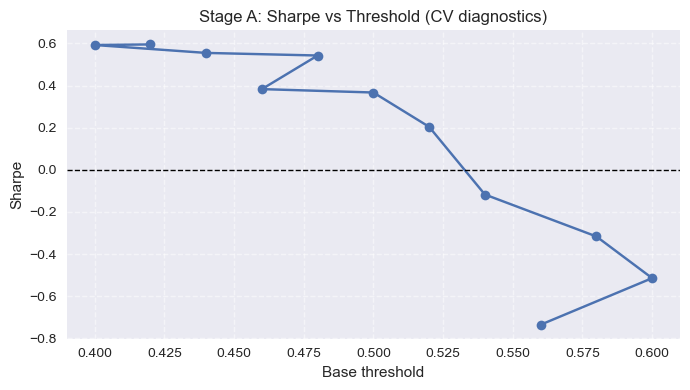

Stage A results saved -> ../outputs/04_ATT_LSTM_clean/threshold_sweep_cv.csv


In [12]:
# ====================================================
# Stage A: Sharpe vs Threshold (CV diagnostics)
# ====================================================

try:
    BTConfig
    run_backtest_clean
except NameError:
    raise RuntimeError("Backtest engine (BTConfig/run_backtest_clean) not found in this notebook.")

# --- Align CV predictions and index ---
if len(preds_cv) != len(idx_cv):
    print(f"⚠️ Mismatch detected: preds={len(preds_cv)}, idx={len(idx_cv)}")
    n = min(len(preds_cv), len(idx_cv))
    preds_cv = preds_cv[:n]
    idx_cv   = idx_cv[:n]

pred_series_cv = pd.Series(preds_cv, index=idx_cv, name="p")

# --- Threshold sweep ---
th_grid = np.round(np.arange(0.40, 0.6001, 0.02), 3)
rows = []
for th in th_grid:
    cfg = BTConfig(
        long_threshold=min(th + 0.05, 0.99),
        short_threshold=max(th - 0.05, 0.01)
    )
    _, stats = run_backtest_clean(df, pred_series_cv, pred_index=idx_cv, cfg=cfg)
    rows.append({
        "threshold": th,
        "sharpe": stats["sharpe"],
        "cagr": stats["cagr"],
        "hit_rate": stats["hit_rate"]
    })

df_sweep = pd.DataFrame(rows).sort_values("sharpe", ascending=False).reset_index(drop=True)
display(df_sweep)

# --- Plot diagnostics ---
plt.figure(figsize=(7, 4))
plt.plot(df_sweep["threshold"], df_sweep["sharpe"], marker="o")
plt.axhline(0, color="k", ls="--", lw=1)
plt.title("Stage A: Sharpe vs Threshold (CV diagnostics)")
plt.xlabel("Base threshold"); plt.ylabel("Sharpe")
plt.grid(True, ls="--", alpha=0.5); plt.tight_layout(); plt.show()

# --- Save results ---
df_sweep.to_csv(OUTPUT_DIR/"threshold_sweep_cv.csv", index=False)
print("Stage A results saved ->", OUTPUT_DIR/"threshold_sweep_cv.csv")


## Stage B – Confirmatory Backtests
Stage B reruns the backtest at fixed thresholds to validate the Stage A sweep and capture full diagnostics for each configuration.

In [13]:
# ============================================
# Stage B – Confirmatory Backtests (CV-based)
# ============================================
import contextlib, io

TUNING_DIR = OUTPUT_DIR / 'tuning'
stage_b_root = TUNING_DIR / 'stageB'
stage_b_root.mkdir(parents=True, exist_ok=True)

stage_b_thresholds = [0.46, 0.50]
stage_b_records = []

def _save_stage_b_returns_plot(df_bt, out_dir):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(df_bt.index, df_bt['log_returns'], label='Actual Returns', alpha=0.45)
    ax.plot(df_bt.index, df_bt['strat_log_ret'], label='Strategy Log Returns', alpha=0.45)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    ax.set_title('Actual Returns vs Strategy Log Returns')
    ax.set_ylabel('Daily Log Returns')
    ax.legend()
    fig.tight_layout()
    fig.savefig(out_dir / 'returns_comparison.png', dpi=200, bbox_inches='tight')
    plt.close(fig)

def _save_stage_b_equity_plot(df_bt, out_dir):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df_bt.index, df_bt['strategy_equity'], label='Strategy Equity Curve', color='blue')
    ax.plot(df_bt.index, df_bt['bh_equity'], label='Buy & Hold Benchmark', color='gray', linestyle='--')
    pred_start = df_bt['p'].first_valid_index()
    if pred_start is not None:
        ax.axvline(pred_start, color='black', linestyle=':', linewidth=0.8, label='Prediction Start')
    ax.set_title('Equity Curve Comparison')
    ax.set_ylabel('Cumulative Value (Rebased)')
    ax.set_xlabel('Date')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.4)
    fig.tight_layout()
    fig.savefig(out_dir / 'equity_curve_strategy.png', dpi=200, bbox_inches='tight')
    plt.close(fig)

def _save_stage_b_relative_plot(df_bt, out_dir):
    rel = df_bt['strategy_equity'] / df_bt['bh_equity']
    pred_start = df_bt['p'].first_valid_index()
    if pred_start is not None:
        base_value = rel.loc[pred_start]
        if np.isfinite(base_value) and base_value != 0:
            rel = rel / base_value
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df_bt.index, rel, label='Strategy vs Benchmark (rebased)', color='green', alpha=0.85)
    ax.axhline(y=1.0, color='black', linestyle=':', linewidth=0.8)
    ax.set_title('Relative Performance vs Benchmark')
    ax.set_ylabel('Relative Ratio (Rebased to 1.0)')
    ax.set_xlabel('Date')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    fig.tight_layout()
    fig.savefig(out_dir / 'relative_performance.png', dpi=200, bbox_inches='tight')
    plt.close(fig)

# --- Run confirmatory tests ---
for base_th in stage_b_thresholds:
    long_th = round(base_th + 0.05, 4)
    short_th = round(base_th - 0.05, 4)
    cfg = BTConfig(long_threshold=long_th, short_threshold=short_th)

    stage_dir = stage_b_root / f'th_{base_th:.2f}'
    stage_dir.mkdir(parents=True, exist_ok=True)

    with contextlib.redirect_stdout(io.StringIO()):
        df_bt, bt_summary = run_backtest_clean(
            df=df,
            predictions=pd.Series(preds_cv, index=idx_cv, name="p"),
            pred_index=idx_cv,
            cfg=cfg,
        )

    _save_stage_b_returns_plot(df_bt, stage_dir)
    _save_stage_b_equity_plot(df_bt, stage_dir)
    _save_stage_b_relative_plot(df_bt, stage_dir)

    stage_b_records.append({
        'threshold': float(base_th),
        'long_threshold': float(long_th),
        'short_threshold': float(short_th),
        'sharpe': float(bt_summary.get('sharpe', np.nan)),
        'cagr': float(bt_summary.get('cagr', np.nan)),
        'max_drawdown': float(bt_summary.get('max_drawdown', np.nan)),
        'turnover': float(bt_summary.get('turnover', np.nan)),
        'hit_rate': float(bt_summary.get('hit_rate', np.nan)),
    })

stage_b_df = pd.DataFrame(stage_b_records)
stage_b_csv = TUNING_DIR / 'stageB_results.csv'
stage_b_df.to_csv(stage_b_csv, index=False)

comparison_cols = ['threshold', 'sharpe', 'cagr', 'max_drawdown', 'turnover', 'hit_rate']
formatters = {
    'threshold': lambda x: f"{x:.2f}",
    'sharpe': lambda x: f"{x:.3f}",
    'cagr': lambda x: f"{x:.3f}",
    'max_drawdown': lambda x: f"{x:.3f}",
    'turnover': lambda x: f"{x:.2f}",
    'hit_rate': lambda x: f"{x:.3f}",
}

print(f'Stage B confirmatory results saved -> {stage_b_csv}')
for base_th in stage_b_thresholds:
    print(f"- {stage_b_root / f'th_{base_th:.2f}'}")

print('Stage B comparison (Sharpe, CAGR, MaxDD, turnover, hit rate):')
print(stage_b_df[comparison_cols].to_string(index=False, formatters=formatters))

stage_b_df


Stage B confirmatory results saved -> ../outputs/04_ATT_LSTM_clean/tuning/stageB_results.csv
- ../outputs/04_ATT_LSTM_clean/tuning/stageB/th_0.46
- ../outputs/04_ATT_LSTM_clean/tuning/stageB/th_0.50
Stage B comparison (Sharpe, CAGR, MaxDD, turnover, hit rate):
threshold sharpe  cagr max_drawdown turnover hit_rate
     0.46  0.383 0.052       -0.182  1198.00    0.479
     0.50  0.367 0.034       -0.103   594.00    0.239


,threshold,long_threshold,short_threshold,sharpe,cagr,max_drawdown,turnover,hit_rate
0,0.46,0.51,0.41,0.382947,0.051505,-0.181598,1198.0,0.478519
1,0.50,0.55,0.45,0.366850,0.033603,-0.103354,594.0,0.238519


### Stage C – Risk / BTConfig grid (fast sweep)

In [14]:
# ============================================
# Stage C – Risk / BTConfig grid (fast sweep, CV)
# ============================================
from itertools import product
import contextlib, io

TUNE_DIR   = OUTPUT_DIR / "tuning"
STAGEC_DIR = TUNE_DIR / "stageC_risk"
STAGEC_DIR.mkdir(parents=True, exist_ok=True)

# Use CV predictions directly
predictions = pd.Series(preds_cv, index=idx_cv, name="p")
pred_index  = idx_cv

# Fix threshold at Stage B winner (e.g., 0.50)
BASE_TH = 0.50
base_kwargs = dict(
    long_threshold = round(BASE_TH + 0.05, 4),
    short_threshold= round(BASE_TH - 0.05, 4),
    neutral_band   = True,
)

# Grid search (without stop_trailing since it's not in BTConfig anymore)
grid = {
    "min_hold_days":    [1, 3, 5],
    "use_vol_targeting":[True],
    "target_annual_vol":[0.08, 0.10, 0.12],
    "max_leverage":     [1.0, 1.5],
    "stop_daily":       [-0.010, -0.015],
    "roll_loss_window": [10, 12],
    "roll_loss_thresh": [-0.030, -0.040],
}

keys = list(grid.keys())
records = []

for vals in product(*[grid[k] for k in keys]):
    kw = dict(zip(keys, vals))
    cfg = BTConfig(**{**base_kwargs, **kw})
    with contextlib.redirect_stdout(io.StringIO()):  # silence prints
        df_bt, summary = run_backtest_clean(
            df=df,
            predictions=predictions,
            pred_index=pred_index,
            cfg=cfg,
        )
    row = {**kw}
    row.update({m: summary.get(m) for m in
                ["sharpe","cagr","max_drawdown","ann_vol","turnover","hit_rate"]})
    records.append(row)

df_stageC = pd.DataFrame(records)
df_stageC = df_stageC.sort_values(["sharpe","cagr"], ascending=[False, False]).reset_index(drop=True)
display(df_stageC.head(10))

out_csv = STAGEC_DIR / "risk_grid.csv"
df_stageC.to_csv(out_csv, index=False)
print(f"Stage C risk grid saved -> {out_csv}")


,min_hold_days,use_vol_targeting,target_annual_vol,max_leverage,stop_daily,roll_loss_window,roll_loss_thresh,sharpe,cagr,max_drawdown,ann_vol,turnover,hit_rate
0,5,True,0.12,1.0,-0.010,10,-0.03,0.571991,0.047799,-0.105792,0.081631,431,0.282222
1,5,True,0.12,1.0,-0.010,10,-0.04,0.571991,0.047799,-0.105792,0.081631,431,0.282222
2,5,True,0.12,1.0,-0.010,12,-0.03,0.571991,0.047799,-0.105792,0.081631,431,0.282222
3,5,True,0.12,1.0,-0.010,12,-0.04,0.571991,0.047799,-0.105792,0.081631,431,0.282222
4,5,True,0.10,1.0,-0.010,10,-0.03,0.544096,0.040659,-0.089188,0.073249,538,0.282222
5,5,True,0.10,1.0,-0.010,10,-0.04,0.544096,0.040659,-0.089188,0.073249,538,0.282222
6,5,True,0.10,1.0,-0.010,12,-0.03,0.544096,0.040659,-0.089188,0.073249,538,0.282222
7,5,True,0.10,1.0,-0.010,12,-0.04,0.544096,0.040659,-0.089188,0.073249,538,0.282222
8,5,True,0.12,1.0,-0.015,10,-0.03,0.540946,0.042833,-0.079932,0.077532,382,0.260741
9,5,True,0.12,1.0,-0.015,12,-0.03,0.540946,0.042833,-0.079932,0.077532,382,0.260741


Stage C risk grid saved -> ../outputs/04_ATT_LSTM_clean/tuning/stageC_risk/risk_grid.csv


### Stage D: Distribution of Model Predictions

In [15]:
pd.Series(preds_cv).describe()

count    1350.000000
mean        0.545432
std         0.028315
min         0.453741
25%         0.525282
50%         0.544967
75%         0.564888
max         0.611594
dtype: float64

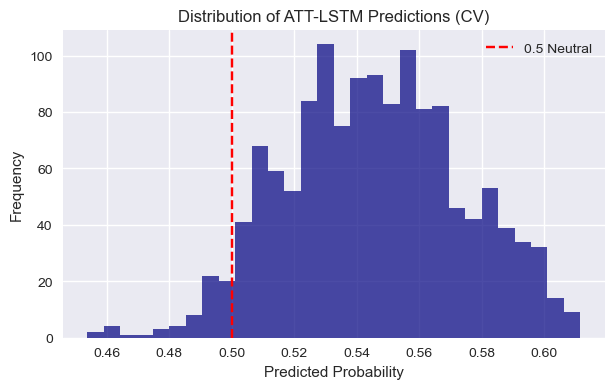

In [16]:
plt.figure(figsize=(7,4))
plt.hist(predictions, bins=30, color="navy", alpha=0.7)  # use Series
plt.axvline(0.5, color="red", linestyle="--", label="0.5 Neutral")
plt.title("Distribution of ATT-LSTM Predictions (CV)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()


### Stage F — CV Threshold Tuning & Diagnostics
- Narrow Threshold Sweep (0.49–0.51)
- Threshold Diagnostics (Trades + Hit Rate, CV)

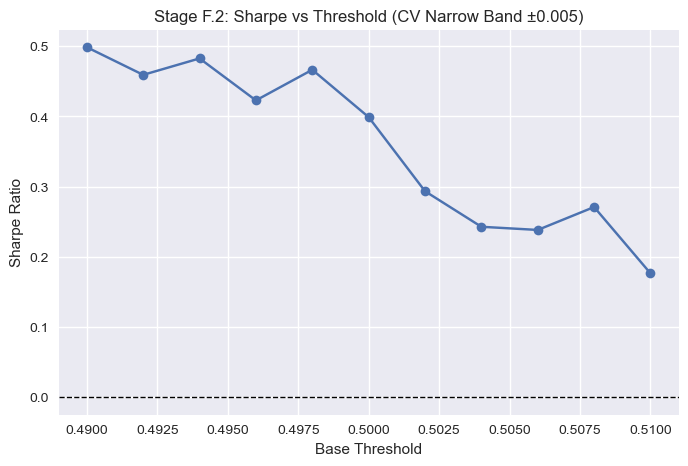

Stage F.2 complete -> ../outputs/04_ATT_LSTM/tuning/stageF2_threshold_sweep.csv


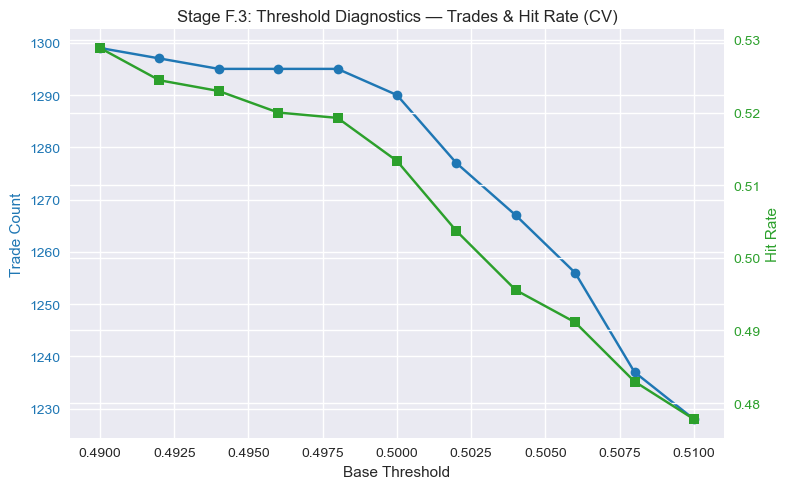

Stage F.3 complete -> ../outputs/04_ATT_LSTM/tuning/stageF3_threshold_diagnostics.csv


In [17]:
# ====================================================
# Stage F.1: Narrow Threshold Sweep (0.49–0.51, CV preds only)
# ====================================================

# --- Force Stage F to use CV only (no OOS leakage) ---
preds_stageF = pd.Series(preds_cv, index=idx_cv, name="p")
pred_idx_stageF = idx_cv

# --- Prepare df_test from CV predictions ---
df_test = df.loc[pred_idx_stageF].copy()
df_test["p"] = preds_stageF
preds = preds_stageF.values  # numpy array for backtest

# --- Define sweep range (±0.005 around 0.50) ---
base_thresholds = np.arange(0.490, 0.5101, 0.002)
results = []

for th in base_thresholds:
    long_th = th + 0.005
    short_th = th - 0.005
    cfg = BTConfig(long_threshold=long_th, short_threshold=short_th, neutral_band=True)

    _, stats = run_backtest_clean(df_test, preds, pred_idx_stageF, cfg=cfg)
    stats["base_threshold"] = th
    results.append(stats)

# --- Collect results ---
df_thresh = pd.DataFrame(results)
df_thresh.to_csv("../outputs/04_ATT_LSTM/tuning/stageF2_threshold_sweep.csv", index=False)

# --- Plot Sharpe vs threshold ---
plt.figure(figsize=(8,5))
plt.plot(df_thresh["base_threshold"], df_thresh["sharpe"], marker="o")
plt.axhline(0, color="black", linestyle="--", lw=1)
plt.title("Stage F.2: Sharpe vs Threshold (CV Narrow Band ±0.005)")
plt.xlabel("Base Threshold")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.show()

print("Stage F.2 complete -> ../outputs/04_ATT_LSTM/tuning/stageF2_threshold_sweep.csv")


# =========================================================
# Stage F.2: Threshold Diagnostics (Trades + Hit Rate, CV)
# =========================================================
trade_counts = []
hit_rates = []

for th in base_thresholds:
    cfg = BTConfig(
        long_threshold=th + 0.005,
        short_threshold=th - 0.005,
        neutral_band=True
    )
    _, stats = run_backtest_clean(df_test, preds, pred_idx_stageF, cfg=cfg)
    trade_counts.append(stats.get('turnover', 0))
    hit_rates.append(stats.get('hit_rate', np.nan))

# --- Collect diagnostics ---
diagnostics_df = pd.DataFrame({
    "threshold": base_thresholds,
    "trade_count": trade_counts,
    "hit_rate": hit_rates
})

diagnostics_df.to_csv("../outputs/04_ATT_LSTM/tuning/stageF3_threshold_diagnostics.csv", index=False)

# --- Plot diagnostics ---
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.set_title("Stage F.3: Threshold Diagnostics — Trades & Hit Rate (CV)")
ax1.plot(diagnostics_df["threshold"], diagnostics_df["trade_count"], 
         marker="o", color="tab:blue", label="Trade Count")
ax1.set_xlabel("Base Threshold")
ax1.set_ylabel("Trade Count", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(diagnostics_df["threshold"], diagnostics_df["hit_rate"], 
         marker="s", color="tab:green", label="Hit Rate")
ax2.set_ylabel("Hit Rate", color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:green")

fig.tight_layout()
plt.show()

print("Stage F.3 complete -> ../outputs/04_ATT_LSTM/tuning/stageF3_threshold_diagnostics.csv")


# AI Strategy Performance Review
## OOS Confirmatory Run (2022+)

=== Stage H: OOS confirmatory (train+val < 2022, predict 2022+) ===
Train+Val done. Final loss ~ 0.6350


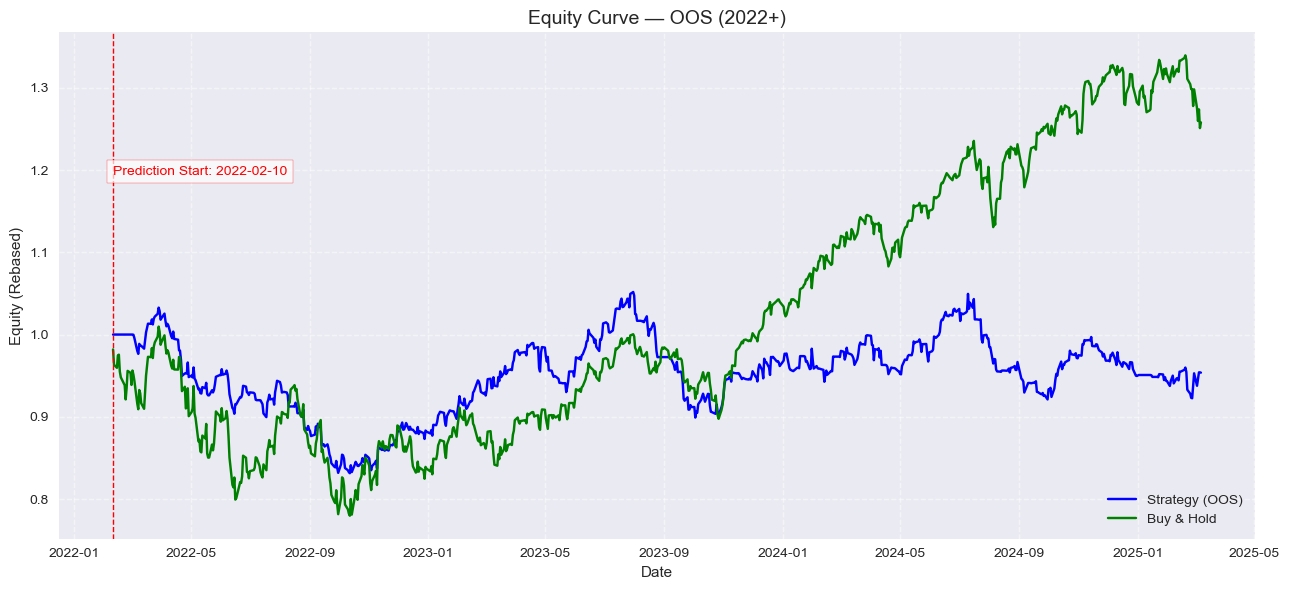

OOS summary:
{'window_start': '2022-02-10', 'window_end': '2025-03-07', 'bars': 770, 'total_return': -0.046300896855968054, 'bh_total_return': 0.25789699737543015, 'cagr': -0.015395300566391601, 'bh_cagr': 0.07798102729749279, 'ann_vol': 0.11809687888338818, 'bh_ann_vol': 0.1728689811264417, 'sharpe': -0.13137551880418624, 'bh_sharpe': 0.43437447211542457, 'max_drawdown': -0.19490260826925143, 'bh_max_drawdown': -0.22769023171927083, 'hit_rate': 0.4077922077922078, 'turnover': 707}


In [18]:
# ======================================================
# Stage H: OOS confirmatory (train+val < 2022, predict 2022+)
# ======================================================

print("=== Stage H: OOS confirmatory (train+val < 2022, predict 2022+) ===")

# --- Define split points ---
VAL_SPLIT = "2020-01-01"   # start of validation
H_SPLIT   = "2022-01-01"   # OOS cutoff

# --- Index sets ---
trainval_idx = df.index[df.index < H_SPLIT]   # all data < 2022
test_idx     = df.index[df.index >= H_SPLIT] # OOS data ≥ 2022

# --- Regime features ---
reg_trval, reg_te = fit_transform_regime_features_fold(
    df, HMM_FEATURE_COLS, trainval_idx, test_idx, RegimeSpec()
)

Xtrval2 = np.hstack([df.loc[trainval_idx, FEATURE_COLS].values, reg_trval])
Xte2    = np.hstack([df.loc[test_idx,     FEATURE_COLS].values, reg_te])

ytrval  = df.loc[trainval_idx, "label"]
yte     = df.loc[test_idx,     "label"]

# --- Scaling (fit on train+val only) ---
sc = StandardScaler().fit(Xtrval2)
Xtrval = sc.transform(Xtrval2)
Xte    = sc.transform(Xte2)

# --- Sequences ---
Xtrval_seq, ytrval_seq = create_sequences(Xtrval, ytrval, SEQ_LEN)
Xte_seq,    yte_seq    = create_sequences(Xte,    yte,    SEQ_LEN)
pred_index_oos = pd.DatetimeIndex(test_idx[SEQ_LEN-1:])  # fixed alignment

# --- Model ---
model = get_stacked_att_lstm(
    (SEQ_LEN, Xtrval_seq.shape[2]),
    lstm_units1=64, lstm_units2=32, 
    dropout=0.2, rec_dropout=0.1, lr=1e-3
)

# Train once on full train+val (<2022), no validation callbacks now
hist = model.fit(
    Xtrval_seq, ytrval_seq,
    epochs=60, batch_size=32, verbose=0
)
print(f"Train+Val done. Final loss ~ {hist.history['loss'][-1]:.4f}")

# --- Predict OOS ---
pred_oos = model.predict(Xte_seq, verbose=0).flatten()
pred_series_oos = pd.Series(pred_oos, index=pred_index_oos, name="p")

# --- Backtest ---
cfg = BTConfig(long_threshold=LONG_THRESHOLD, short_threshold=SHORT_THRESHOLD)
df_bt_oos, summary_oos = run_backtest_clean(
    df=df, predictions=pred_series_oos, pred_index=pred_index_oos, cfg=cfg
)

# --- Save artifacts ---
oos_dir = OUTPUT_DIR/"oos_final"
oos_dir.mkdir(parents=True, exist_ok=True)
np.save(oos_dir/"pred_oos.npy", pred_oos)
np.save(oos_dir/"pred_index_oos.npy", pred_index_oos.values.astype("datetime64[ns]"))
pd.DataFrame([summary_oos]).to_csv(oos_dir/"backtest_oos_summary.csv", index=False)

# --- Plot equity curve ---
plt.figure(figsize=(13, 6))
plt.plot(df_bt_oos.loc[pred_index_oos].index,
         df_bt_oos.loc[pred_index_oos, "strategy_equity"],
         label="Strategy (OOS)", color="blue")
plt.plot(df_bt_oos.loc[pred_index_oos].index,
         df_bt_oos.loc[pred_index_oos, "bh_equity"],
         label="Buy & Hold", color="green")

pred_start = pred_index_oos[0]
plt.axvline(pred_start, color="red", linestyle="--", linewidth=1)
plt.text(pred_start,
         df_bt_oos["bh_equity"].max() * 0.9,
         f"Prediction Start: {pred_start.date()}",
         rotation=0, color="red", ha="left", va="top", fontsize=10,
         bbox=dict(facecolor="white", alpha=0.7, edgecolor="red"))

plt.title("Equity Curve — OOS (2022+)", fontsize=14)
plt.xlabel("Date"); plt.ylabel("Equity (Rebased)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(oos_dir/"equity_curve_oos_enhanced.png", dpi=300, bbox_inches="tight")
plt.show()

print("OOS summary:"); print(summary_oos)


### Actual Returns vs Predicted Returns
Shows how well the signals align with actual movements.

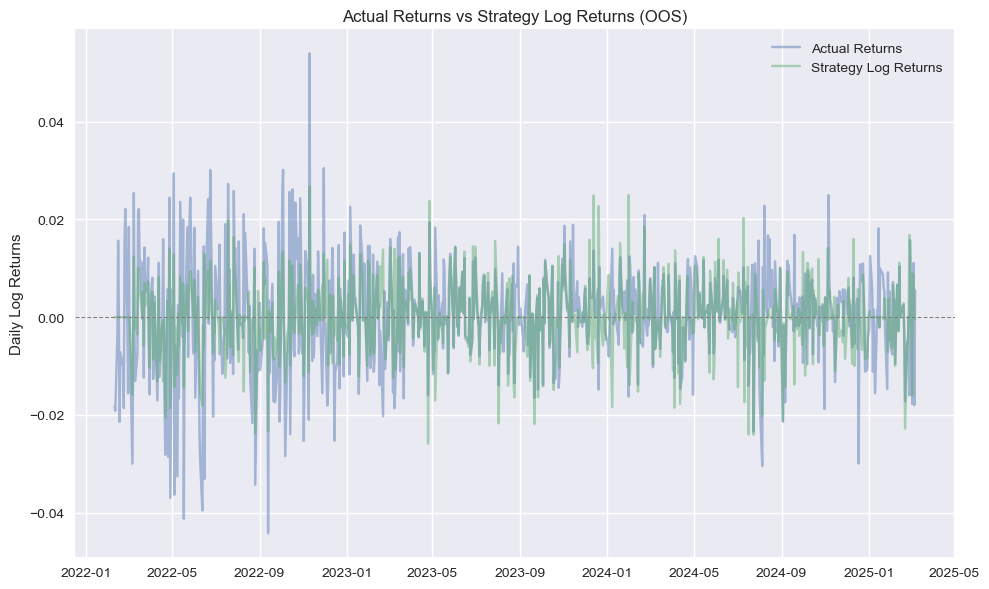

In [19]:
# ======================================================
# Plot: Actual vs Strategy Returns (OOS)
# ======================================================

plt.figure(figsize=(10, 6))
plt.plot(df_bt_oos.index, df_bt_oos['log_returns'], 
         label="Actual Returns", alpha=0.45)
plt.plot(df_bt_oos.index, df_bt_oos['strat_log_ret'], 
         label="Strategy Log Returns", alpha=0.45)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.title("Actual Returns vs Strategy Log Returns (OOS)")
plt.ylabel("Daily Log Returns")
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'returns_comparison_oos.png', dpi=300, bbox_inches='tight')
plt.show()


## `quantstats` Analytics Module

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2022-03-03   2022-03-03
End Period          2025-03-07   2025-03-07
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       94.0%

Cumulative Return   31.54%       -4.63%
CAGR﹪              6.48%        -1.08%

Sharpe              0.62         -0.07
Prob. Sharpe Ratio  85.72%       44.97%
Sortino             0.88         -0.1
Sortino/√2          0.62         -0.07
Omega               0.99         0.99

Max Drawdown        -22.77%      -19.49%
Longest DD Days     622          585

Gain/Pain Ratio     0.11         -0.01
Gain/Pain (1M)      0.53         -0.04

Payoff Ratio        1.08         1.17
Profit Factor       1.11         0.99
Common Sense Ratio  1.18         0.95
CPC Index           0.63         0.51
Tail Ratio          1.06         0.96
Outlier Win Ratio   2.74         3.97
Outlier Loss Ratio  3.31         5.09

MTD                 -3.1%        0.09%
3M       

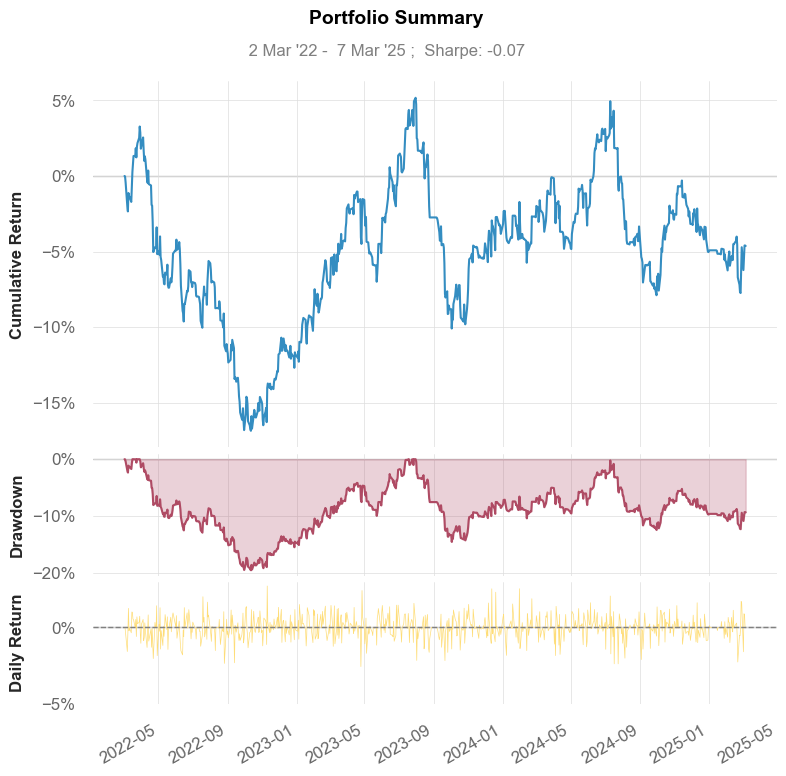

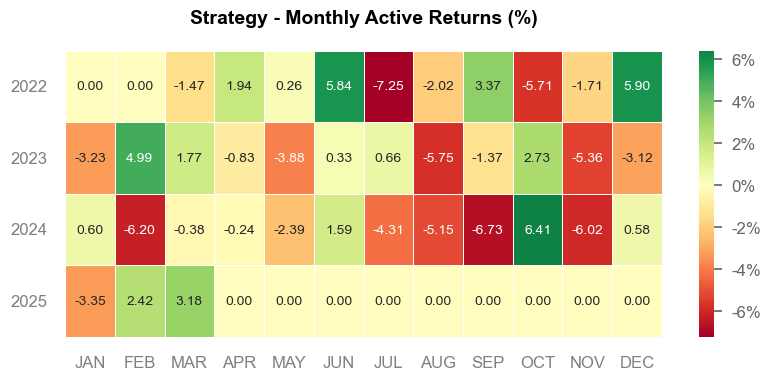

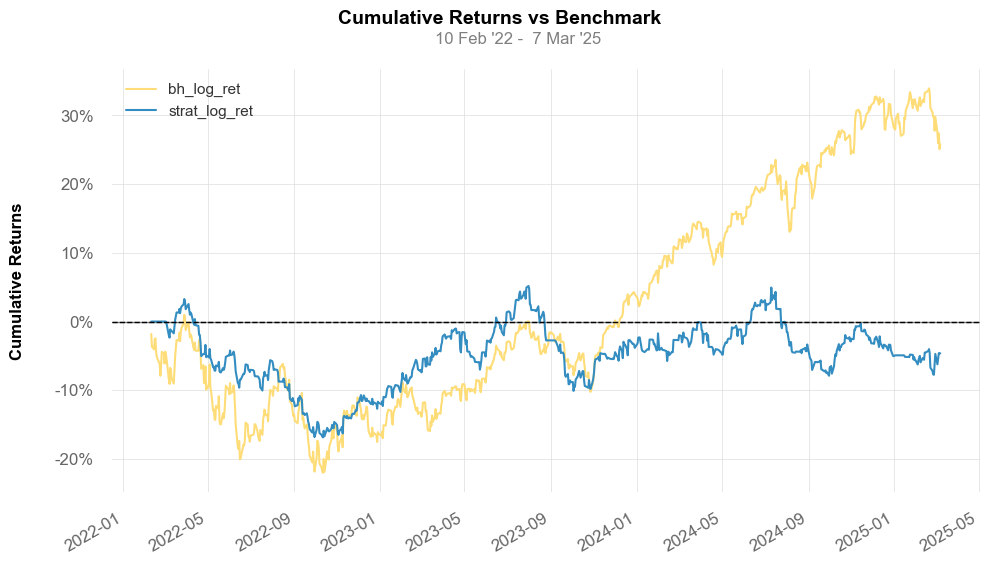

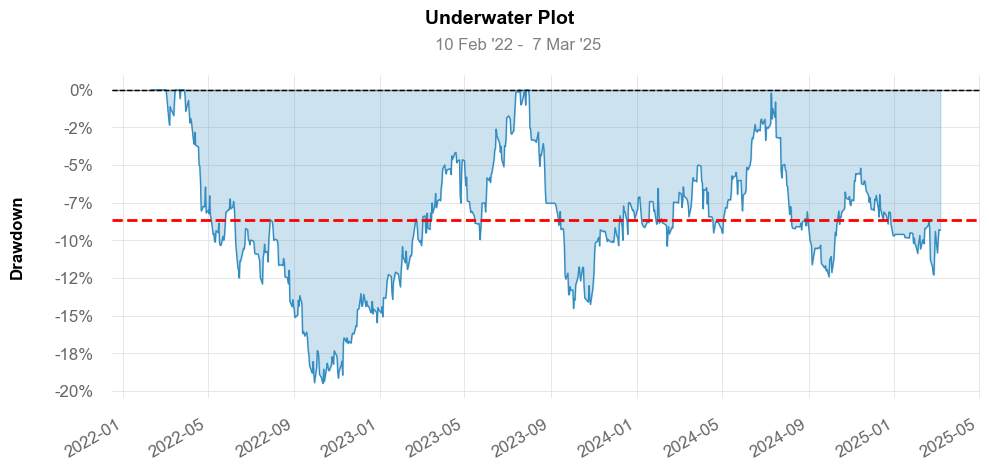

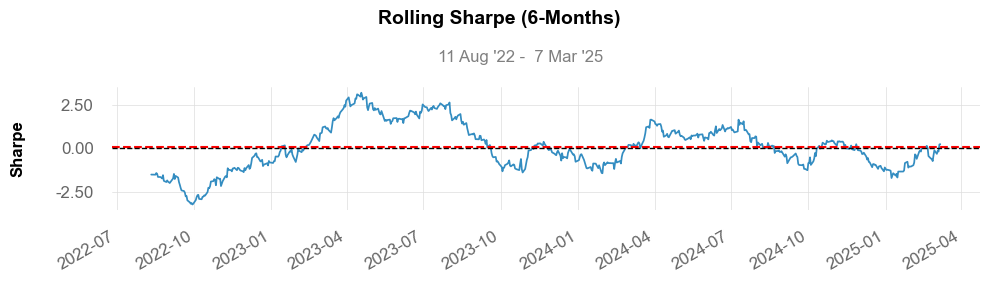

In [20]:
# ====================================================
# Stage H: QuantStats Analysis (OOS Backtest 2022+)
# ===================================================
import quantstats as qs

# Convert log returns to simple daily returns
strategy_simple_returns = np.exp(df_bt_oos['strat_log_ret']) - 1
benchmark_simple_returns = np.exp(df_bt_oos['bh_log_ret']) - 1

# Generate a Performance Report
qs.reports.basic(strategy_simple_returns, benchmark=benchmark_simple_returns)

# Cumulative Returns Comparison (Strategy vs. Benchmark)
qs.plots.returns(strategy_simple_returns, benchmark=benchmark_simple_returns)

# Drawdown Analysis
qs.plots.drawdown(strategy_simple_returns)

# Rolling Sharpe Ratio
qs.plots.rolling_sharpe(strategy_simple_returns)

## OOS Stress Test: Why 2022+?

We deliberately select **2022 onwards** as the out-of-sample (OOS) evaluation window.  
This period represents one of the most challenging market regimes in recent history:

- **Rate Shock:** The Fed executed its fastest tightening cycle since the Volcker era, driving rates from near-zero to 4.5%+ within a year.  
- **Correlation Breakdown:** Both equities and Treasuries sold off together, breaking the classic 60/40 diversification.  
- **Volatility Spikes:** Equity (VIX), bond (MOVE), and FX volatilities surged simultaneously.  
- **Liquidity Stress:** Quantitative tightening (QT) drained market liquidity and widened credit spreads.  
- **Macro Narrative Shifts:** Inflation shock → policy shock → earnings compression.

By validating the Attention-LSTM on this window, we **stress test robustness under adverse macro conditions** rather than just capturing momentum in easy bull markets.  
Even modest Sharpe ratios in this regime are meaningful, since most strategies struggled to adapt.
